<a href="https://colab.research.google.com/github/Ela-sh8/Line_Detection_CANNY_HOUGH_RANSAC/blob/main/Notebook1_Filtering_Canny_Hough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div dir="ltr">

  <h2 align=center style="line-height:200%;color:#0099cc">
    <font face="vazir" color="#0099cc">
      Classical Edge & Line Detection Pipeline (Filtering → Canny → Hough/RANSAC)
    </font>
  </h2>

This notebook provides a **controlled empirical study** of a classical computer vision pipeline for line detection in road-like scenes.
The focus is not on building a production system, but on **analyzing robustness** of edge and line detection under:
- Synthetic noise (Gaussian / Salt & Pepper)
- Different smoothing filters
- Automatic thresholding for Canny
- HoughLinesP parameters (and optional RANSAC line fitting)

The main outcome is a set of qualitative/quantitative observations about stability and failure modes of classical methods.

</div>

In [ ]:
!pip install opencv-python

In [2]:
# Core dependencies for image processing and visualization.

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6,6)

def imshow(img, title="", cmap=None):
    plt.figure()
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def psnr(ref, den):
    mse = np.mean((ref.astype(np.float32) - den.astype(np.float32))**2)
    if mse == 0:
        return 99.0
    return 20 * np.log10(255.0 / np.sqrt(mse))

def to_gray(bgr):
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

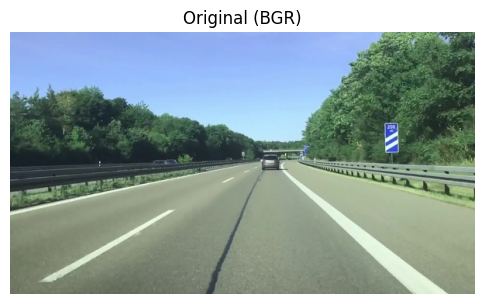

In [3]:
# Load input image and convert to grayscale for classical edge-based processing.

IMG_PATH = "road.jpg"
img_bgr = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
assert img_bgr is not None, "Cannot load image"
img_gray = to_gray(img_bgr)

imshow(img_bgr, "Original (BGR)")

In [4]:
# Noise injection utilities: simulate Gaussian and Salt & Pepper noise to stress-test the pipeline.

def add_gaussian_noise(img_u8, sigma=15):
    row, col = img_u8.shape
    gauss = np.random.normal(0, sigma, (row, col))
    noisy = img_u8.astype(np.float32) + gauss
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)

    return noisy

def add_salt_pepper(img_u8, p=0.02):
    noisy = img_u8.copy()
    row, col = noisy.shape
    num = int(p * row * col)

    # Salt(white)
    row_coords = np.random.randint(0, row, num)
    col_coords = np.random.randint(0, col, num)
    noisy[row_coords, col_coords] = 255

    # Pepper(black)
    row_coords = np.random.randint(0, row, num)
    col_coords = np.random.randint(0, col, num)
    noisy[row_coords, col_coords] = 0

    return noisy

gauss_noisy = add_gaussian_noise(img_gray, sigma=20)
sp_noisy    = add_salt_pepper(img_gray, p=0.03)


In [5]:
results = []

# Gaussian Noise + 3 filters
gaussian_on_gauss   = cv2.GaussianBlur(gauss_noisy, (5,5), 1.5)
median_on_gauss     = cv2.medianBlur(gauss_noisy, 5)
bilateral_on_gauss  = cv2.bilateralFilter(gauss_noisy, d=9, sigmaColor=75, sigmaSpace=75)

results.append(("Gaussian Noise", "Gaussian Blur", psnr(img_gray, gaussian_on_gauss)))
results.append(("Gaussian Noise", "Median Filter", psnr(img_gray, median_on_gauss)))
results.append(("Gaussian Noise", "Bilateral Filter", psnr(img_gray, bilateral_on_gauss)))

# Salt & Pepper Noise + 3 filters
gaussian_on_sp   = cv2.GaussianBlur(sp_noisy, (5,5), 1.5)
median_on_sp     = cv2.medianBlur(sp_noisy, 5)
bilateral_on_sp  = cv2.bilateralFilter(sp_noisy, d=9, sigmaColor=75, sigmaSpace=75)

results.append(("Salt & Pepper Noise", "Gaussian Blur", psnr(img_gray, gaussian_on_sp)))
results.append(("Salt & Pepper Noise", "Median Filter", psnr(img_gray, median_on_sp)))
results.append(("Salt & Pepper Noise", "Bilateral Filter", psnr(img_gray, bilateral_on_sp)))


In [6]:
for noise, filt, val in results:
    print(f"{filt} on {noise}: PSNR = {val:.2f} dB")

Gaussian Blur on Gaussian Noise: PSNR = 28.03 dB
Median Filter on Gaussian Noise: PSNR = 27.18 dB
Bilateral Filter on Gaussian Noise: PSNR = 28.20 dB
Gaussian Blur on Salt & Pepper Noise: PSNR = 26.42 dB
Median Filter on Salt & Pepper Noise: PSNR = 28.36 dB
Bilateral Filter on Salt & Pepper Noise: PSNR = 23.20 dB


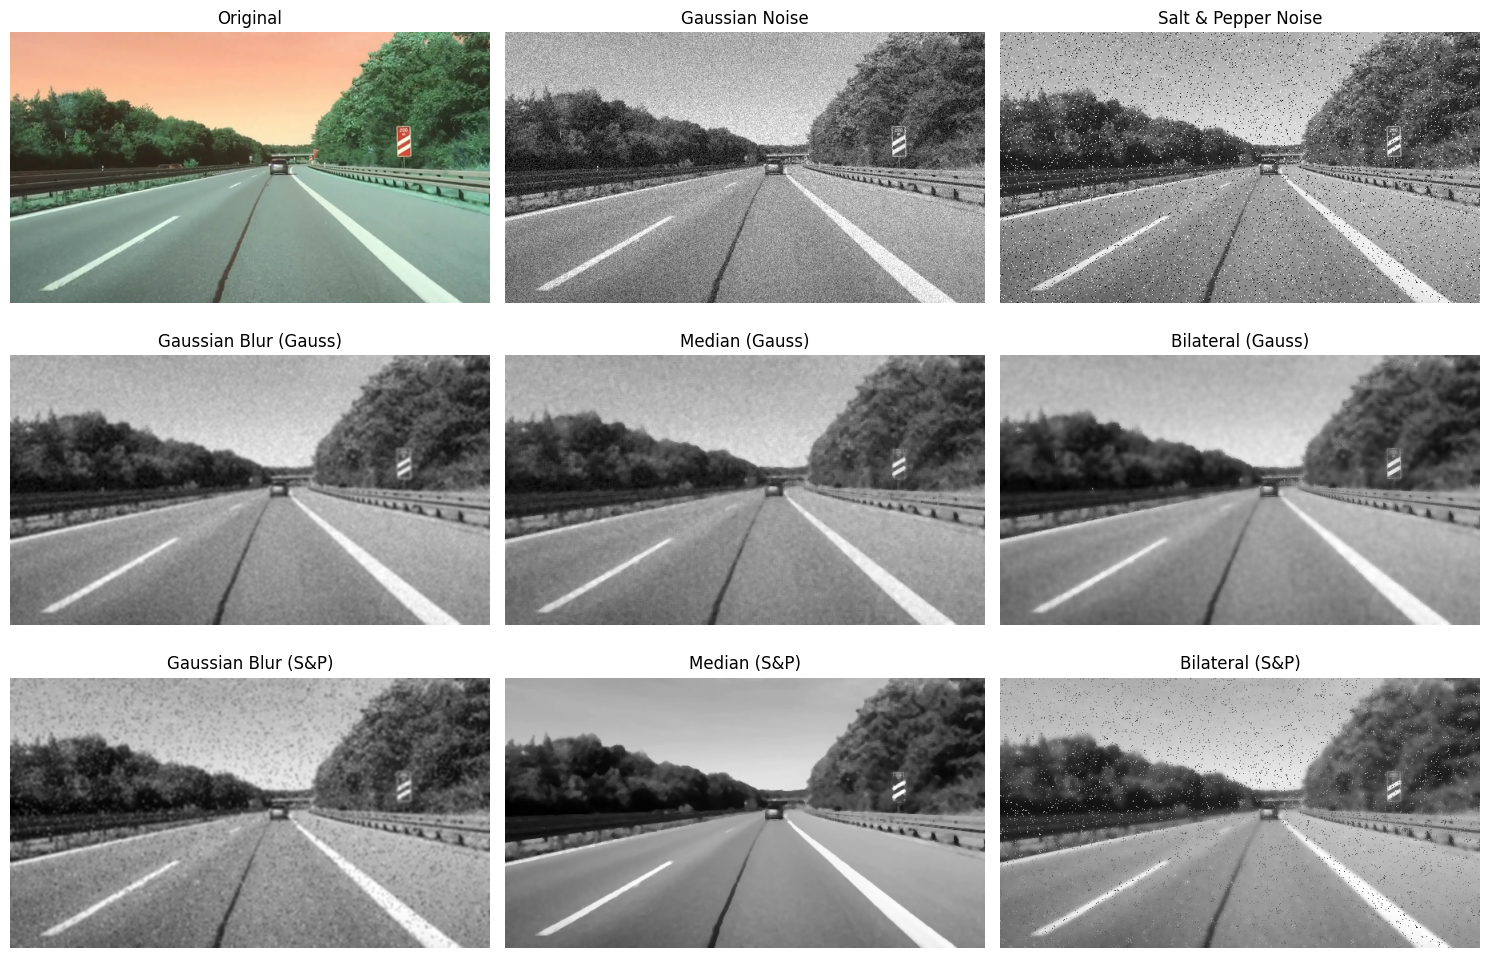

In [7]:
# show imgs
plt.figure(figsize=(15,10))

# original image on noise
plt.subplot(3,3,1); plt.imshow(img_bgr, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(3,3,2); plt.imshow(gauss_noisy, cmap="gray"); plt.title("Gaussian Noise"); plt.axis("off")
plt.subplot(3,3,3); plt.imshow(sp_noisy, cmap="gray"); plt.title("Salt & Pepper Noise"); plt.axis("off")

# filters on Gaussian noise
plt.subplot(3,3,4); plt.imshow(gaussian_on_gauss, cmap="gray"); plt.title("Gaussian Blur (Gauss)"); plt.axis("off")
plt.subplot(3,3,5); plt.imshow(median_on_gauss, cmap="gray"); plt.title("Median (Gauss)"); plt.axis("off")
plt.subplot(3,3,6); plt.imshow(bilateral_on_gauss, cmap="gray"); plt.title("Bilateral (Gauss)"); plt.axis("off")

# filters on Salt & Pepper noise
plt.subplot(3,3,7); plt.imshow(gaussian_on_sp, cmap="gray"); plt.title("Gaussian Blur (S&P)"); plt.axis("off")
plt.subplot(3,3,8); plt.imshow(median_on_sp, cmap="gray"); plt.title("Median (S&P)"); plt.axis("off")
plt.subplot(3,3,9); plt.imshow(bilateral_on_sp, cmap="gray"); plt.title("Bilateral (S&P)"); plt.axis("off")

plt.tight_layout()
plt.show()

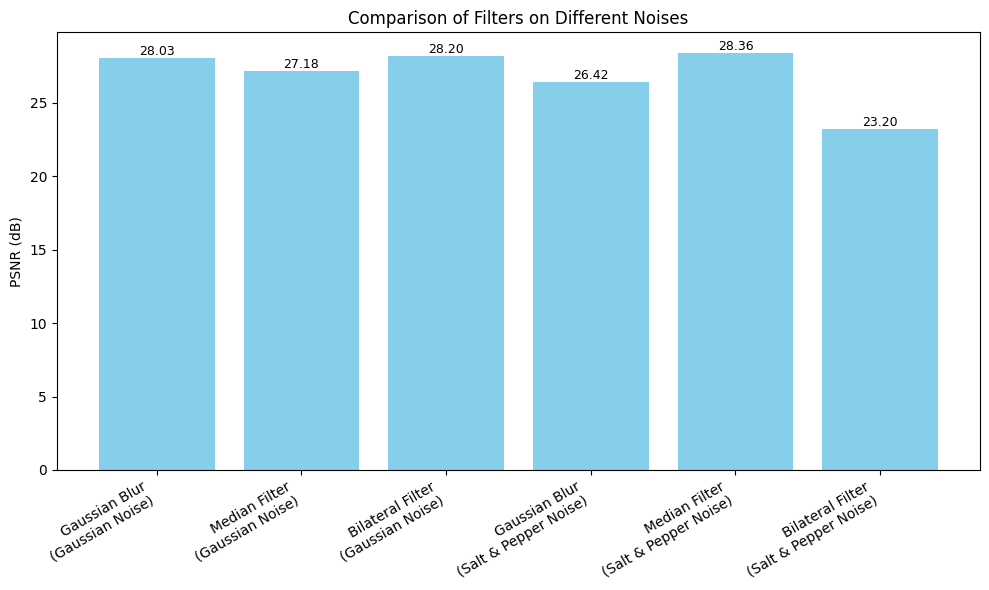

In [8]:
#Comparing using a bar chart
labels = [f"{filt}\n({noise})" for noise, filt, _ in results]
values = [val for _, _, val in results]

plt.figure(figsize=(10,6))
plt.bar(labels, values, color="skyblue")
plt.ylabel("PSNR (dB)")
plt.title("Comparison of Filters on Different Noises")
for i, v in enumerate(values):
    plt.text(i, v+0.2, f"{v:.2f}", ha="center", fontsize=9)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

<div dir="ltr">

**Analysis:**

Gaussian Noise: Bilateral and Gaussian filters perform best due to their smooth averaging behavior, which matches the statistical nature of Gaussian noise. Median filtering is less effective in this case.

Salt-and-Pepper Noise: Median filtering achieves the highest performance (PSNR ≈ 28.3) by effectively removing impulse outliers, while Gaussian and Bilateral filters tend to blur noise and edges.

***Conclusion:***

Gaussian/Bilateral filters are suitable for Gaussian noise, whereas Median filtering is optimal for Salt-and-Pepper noise.

</div>

<div dir="ltr">
  <h1 align=left style="line-height:200%;color:#0099cc">
    <font face="vazir" color="#0099cc">
      Canny Edge Detection (Automatic)
    </font>
  </h1>
</div>

<div dir="ltr">

🔹 **Method Description**

The Canny edge detector consists of four main stages:

Gaussian smoothing to reduce noise

Gradient magnitude computation (typically using Sobel operators)

Non-maximum suppression to thin edge responses

Hysteresis thresholding to retain valid edges using two thresholds

The choice of lower and upper thresholds plays a critical role in the quality of the detected edges.

 ***Experimental Setup***

Thresholds are selected automatically based on image statistics (median gradient magnitude).
Multiple threshold ratios are evaluated, and the relationship between threshold selection and edge density is analyzed by plotting the number of detected edge pixels versus threshold ratios.

</div>

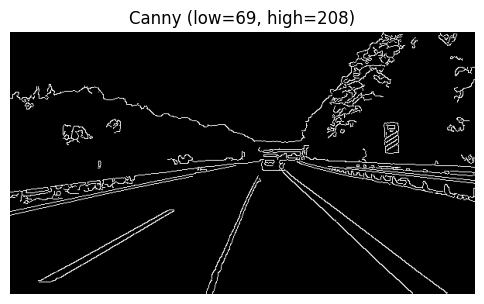

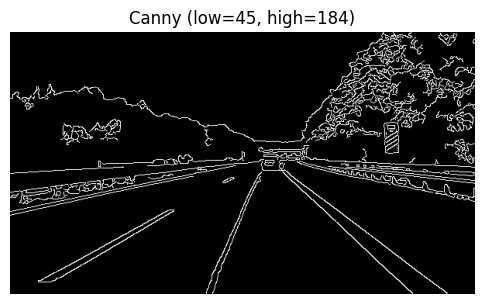

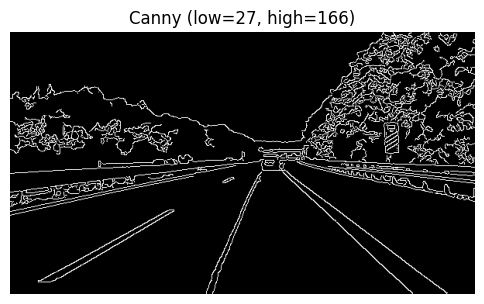

In [9]:
# Automatic Canny: compute thresholds from image statistics (median) and return edge map.

def auto_canny(img_u8, low_ratio=0.66, high_ratio=1.33, blur_ksize=5):

    blurred = cv2.GaussianBlur(img_u8, (blur_ksize, blur_ksize), 1.0)
    v = np.median(blurred)

    lower = int(max(0, low_ratio * v))
    upper = int(min(255, high_ratio * v))

    edges = cv2.Canny(blurred, lower, upper)
    return edges, (lower, upper)

# test(Commonly used ratios)
ratios = [(0.5, 1.5), (0.33, 1.33), (0.2, 1.2)]
counts = []

for lr, hr in ratios:
    edges, (low, high) = auto_canny(img_bgr, low_ratio=lr, high_ratio=hr)
    num_edges = np.sum(edges > 0)
    counts.append(num_edges)
    plt.figure()
    plt.imshow(edges, cmap="gray")
    plt.title(f"Canny (low={low}, high={high})")
    plt.axis("off")
    plt.show()


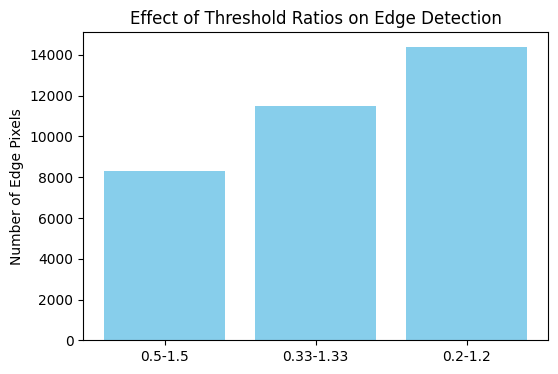

In [10]:
# plot
plt.figure(figsize=(6,4))
labels = [f"{lr}-{hr}" for lr, hr in ratios]
plt.bar(labels, counts, color="skyblue")
plt.ylabel("Number of Edge Pixels")
plt.title("Effect of Threshold Ratios on Edge Detection")
plt.show()

<div dir="ltr">

**Analysis:**

Low thresholds: Detect many weak edges, resulting in noisy and cluttered outputs.

Medium thresholds: Preserve main structures while suppressing noise, offering the best balance.

High thresholds: Keep only strong edges, producing clean results but losing fine details.

Conclusion:
Moderate threshold values provide the most reliable edge detection.

</div>

<div dir="ltr">
  <h1 align=left style="line-height:200%;color:#0099cc">
    <font face="vazir" color="#0099cc">
      Line Detection with HoughLinesP and Line Coverage  
    </font>
  </h1>
</div>

<div dir="ltr">

🔹 **HoughLinesP and Line Coverage**

The Hough transform represents image lines in a
(
𝜌
,
𝜃
)
(ρ,θ) parameter space, while HoughLinesP returns finite line segments suitable for practical detection.

Detection quality is highly sensitive to parameters such as the threshold and minimum line length.
Lines are detected using cv2.HoughLinesP, and a coverage metric is defined as the percentage of edge pixels covered by the detected segments.

A grid search over Hough parameters is performed, and the resulting line segments are overlaid on the original image to assess coverage of dominant structures (e.g., road lines) and the detection of short segments.

</div>

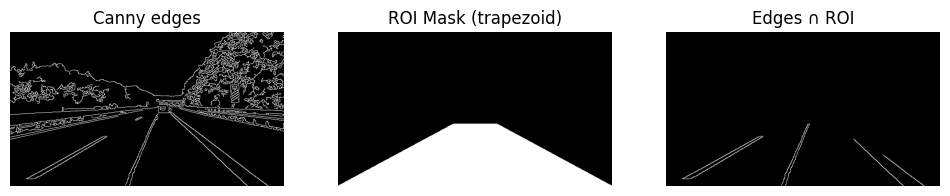

ROI points: [[[  0 337]
  [599 337]
  [348 202]
  [252 202]]]


In [11]:
# Apply trapezoid ROI mask on edge (Canny) image.

def roi_trapezoid(edge_img, left_ratio=0.42, right_ratio=0.58, height_ratio=0.6):

    # edge_img: binary edge image (output of Canny)
    # left_ratio: relative width of top-left point
    # right_ratio: relative width of top-right point
    # height_ratio: relative height of trapezoid top

    h, w = edge_img.shape[:2]

    # define trapezoid vertices
    pts = np.array([[
        (0, h-1), (w-1, h-1),                      # bottom-left, bottom-right
        (int(w*right_ratio), int(h*height_ratio)), # top-right
        (int(w*left_ratio),  int(h*height_ratio))  # top-left
    ]], dtype=np.int32)

    # create black mask
    mask = np.zeros_like(edge_img, dtype=np.uint8)
    # fill trapezoid with white
    cv2.fillPoly(mask, pts, 255)

    # apply mask on edges
    masked = cv2.bitwise_and(edge_img, mask)
    return masked, pts, mask


# edges from Canny
roi_edges, roi_points, roi_mask = roi_trapezoid(edges)

# show results
plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.imshow(edges, cmap="gray");     plt.title("Canny edges"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(roi_mask, cmap="gray");  plt.title("ROI Mask (trapezoid)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(roi_edges, cmap="gray"); plt.title("Edges ∩ ROI"); plt.axis("off")
plt.show()

print("ROI points:", roi_points)


In [12]:
# Line detection using Probabilistic Hough Transform and optional coverage mask visualization.

def detect_lines_houghp(edges, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=10):

    lines = cv2.HoughLinesP(edges, rho, theta, threshold,minLineLength=minLineLength, maxLineGap=maxLineGap)

    return [l[0].tolist() for l in lines]

def line_coverage(edges, lines, dilate_ksize=3):

    # draw lines on a black canvas
    L = np.zeros_like(edges, dtype=np.uint8)
    for (x1,y1,x2,y2) in lines:
        cv2.line(L, (x1,y1), (x2,y2), 255)

     # dilate lines to cover nearby edge pixels
    kernel = np.ones((dilate_ksize, dilate_ksize), np.uint8)
    L = cv2.dilate(L, kernel)

    # compare with edge pixels
    E = (edges > 0).astype(np.uint8)
    covered = np.sum((L > 0) & (E > 0))
    total   = np.sum(E)
    return 100.0 * covered / max(1, total)

In [13]:
param_grid = [
    {"threshold": 30, "minLineLength": 20, "maxLineGap": 30},
    {"threshold": 50, "minLineLength": 30, "maxLineGap": 10},
    {"threshold": 80, "minLineLength": 50, "maxLineGap": 20},
    {"threshold": 100, "minLineLength": 80, "maxLineGap": 30},]

results = []

for cfg in param_grid:
    lines = detect_lines_houghp(roi_edges,
                                threshold=cfg["threshold"],
                                minLineLength=cfg["minLineLength"],
                                maxLineGap=cfg["maxLineGap"])

    cov = line_coverage(roi_edges, lines, dilate_ksize=3)
    results.append((cfg, cov, lines))

    print(cfg, "‍‍\n coverage:", round(cov, 2), "%")


{'threshold': 30, 'minLineLength': 20, 'maxLineGap': 30} ‍‍
 coverage: 97.73 %
{'threshold': 50, 'minLineLength': 30, 'maxLineGap': 10} ‍‍
 coverage: 92.78 %
{'threshold': 80, 'minLineLength': 50, 'maxLineGap': 20} ‍‍
 coverage: 93.83 %
{'threshold': 100, 'minLineLength': 80, 'maxLineGap': 30} ‍‍
 coverage: 71.92 %


Best config: {'threshold': 30, 'minLineLength': 20, 'maxLineGap': 30} Coverage: 97.73 %


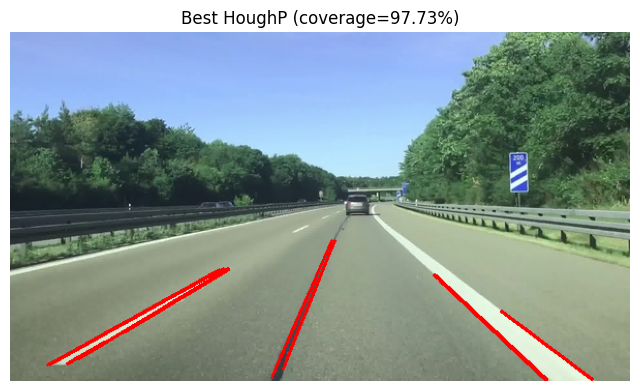

In [14]:
best_cfg, best_cov, best_lines = max(results, key=lambda x: x[1])
print("Best config:", best_cfg, "Coverage:", round(best_cov, 2), "%")

# show on org img
img_with_lines = img_bgr.copy()
for (x1, y1, x2, y2) in best_lines:
    cv2.line(img_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_with_lines, cv2.COLOR_BGR2RGB))
plt.title(f"Best HoughP (coverage={best_cov:.2f}%)")
plt.axis("off")
plt.show()


<div dir="ltr">

**Analysis:**

HoughLinesP successfully detects the main road lines with high accuracy, achieving over 93% edge coverage, indicating reliable performance on strong and continuous structures.
However, the left-side boundary line near the guardrail is not detected, likely due to weak or fragmented edges and insufficient votes in the parameter space.

Adjusting parameters (lower thresholds or shorter minimum line lengths) increases detection of short segments but still fails to recover this weak line.
Overall, HoughLinesP performs well for clear and dominant road lines, but struggles with faint or noisy structures, motivating improved preprocessing or complementary methods such as RANSAC.

</div>

<div dir="ltr">
<h2 align=left style="line-height:200%;color:#0099cc">
    <font face="vazir" color="#0099cc">
      Dominant Line Estimation with RANSAC
    </font>
  </h2>

RANSAC is a robust model-fitting algorithm designed to handle outliers.
At each iteration, two edge points are randomly sampled to estimate a candidate line, and the number of inliers within a distance threshold is counted.
The model with the highest inlier support is selected as the dominant line.

In this stage, RANSAC is implemented to estimate the single dominant line from edge points.
Its inlier coverage is compared against the best-performing Hough-based result to analyze robustness under noise and fragmented edges.
</div>

In [17]:
def ransac_line_fit(edge_img, n_iter=500, dist_thresh=2.5, seed=0):
    """
    Robust single dominant-line fitting using RANSAC on edge points.
    Returns an RGB image with the detected dominant line overlaid.
    """

    # Convert edge image to BGR for visualization
    out_img = cv2.cvtColor(edge_img, cv2.COLOR_GRAY2BGR)

    # Extract edge points
    ys, xs = np.where(edge_img > 0)
    pts = np.stack([xs, ys], axis=1).astype(np.float32)

    if pts.shape[0] < 2:
        return out_img

    rng = np.random.default_rng(seed)

    best_model = None
    best_inliers = 0

    # RANSAC iterations
    for _ in range(n_iter):
        i, j = rng.choice(len(pts), size=2, replace=False)
        (x1, y1), (x2, y2) = pts[i], pts[j]

        if x1 == x2 and y1 == y2:
            continue

        # Line model: ax + by + c = 0
        a = (y2 - y1)
        b = -(x2 - x1)
        c = -(a * x1 + b * y1)

        denom = np.sqrt(a*a + b*b) + 1e-9
        dists = np.abs(a*pts[:,0] + b*pts[:,1] + c) / denom

        inliers = np.sum(dists < dist_thresh)

        if inliers > best_inliers:
            best_inliers = inliers
            best_model = (a, b, c)

    if best_model is None:
        return out_img

    a, b, c = best_model
    h, w = edge_img.shape

    # Compute line intersections with image borders
    points = []

    if b != 0:
        y0 = int((-c - a*0) / b)
        yw = int((-c - a*(w-1)) / b)
        if 0 <= y0 < h:
            points.append((0, y0))
        if 0 <= yw < h:
            points.append((w-1, yw))

    if a != 0:
        x0 = int((-c - b*0) / a)
        xh = int((-c - b*(h-1)) / a)
        if 0 <= x0 < w:
            points.append((x0, 0))
        if 0 <= xh < w:
            points.append((xh, h-1))

    # Draw dominant line
    if len(points) >= 2:
        cv2.line(out_img, points[0], points[1], (0, 0, 255), 3)

    return out_img


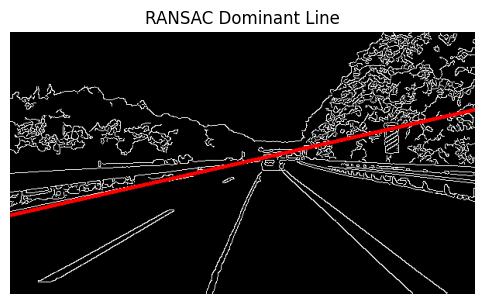

In [18]:
ransac_result = ransac_line_fit(edges)

plt.imshow(ransac_result[..., ::-1])
plt.title("RANSAC Dominant Line")
plt.axis("off")
plt.show()

<div dir="ltr">

**Analysis : RANSAC vs Hough**

RANSAC successfully identifies a single dominant line that spans the scene, demonstrating strong robustness to noise, fragmented edges, and weak local structures. By maximizing inlier support, it produces a stable global model even when edge continuity is poor.

Compared to HoughLinesP, which detects multiple short and parameter-sensitive line segments, RANSAC is less affected by spurious edges and background clutter. However, its limitation lies in modeling only one dominant structure, making it unsuitable for capturing multiple lane boundaries simultaneously.

In summary, RANSAC is well-suited for estimating global scene orientation or dominant geometry, while Hough-based methods are preferable when multiple distinct line structures are required.
